In [10]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [11]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrAandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_C'

#file name
fname='F0217_FO_IMA_70030012_FORF253_CAL_0084-0093_Hsouth.fits'

#Name of field
field='HSouth'

#wavelength of data
wavelength=25.2

In [12]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

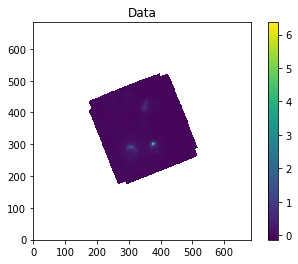

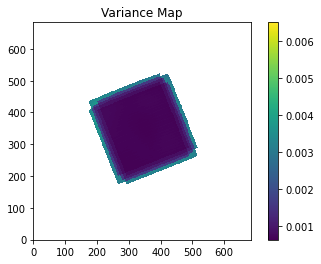

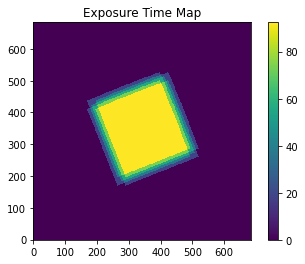

In [13]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

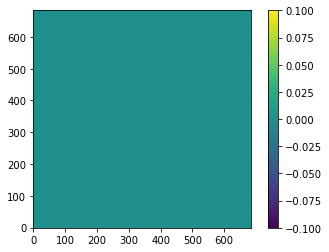

In [14]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.5,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
#mask2[0:40,0:340]=1
#mask2[0:100,300:340]=1

mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [15]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

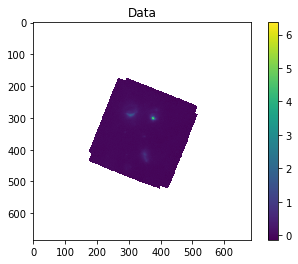

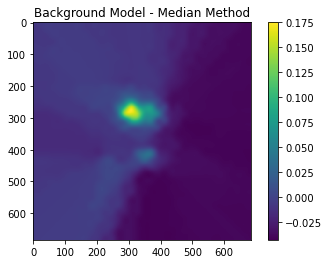

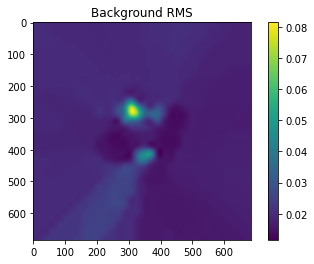

In [16]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [17]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

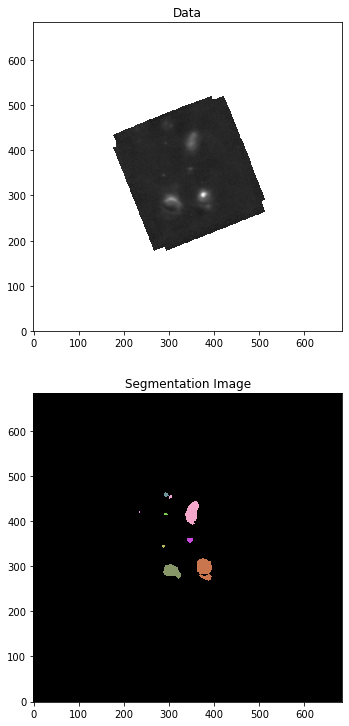

In [18]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [19]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,377.5152735859397,298.89531355382223,"266.3686747963974,-28.935107161877877",-0.011826144465053636,0.04634227014924898,58.53028719850146,1263.0,8.092971409726378,5.765054103876495,-74.30635080004099,0.029003665714342,0.007718521264284996,0.016352392248050324,0.701821141361889,0.28764679720134945,1.403797998059474,16.54519044704894,664.4300974184445,nan,1.3150276135472743,658.3417643012825,nan
2,307.10955838018106,289.65713923468724,"266.3858372347621,-28.937078029781063",0.04973997174237778,0.14717543200259658,122.15560856215517,830.0,8.832980338288136,5.302355306236961,-17.964972105742937,0.014981356898137389,0.013350342535406753,0.033403853905031214,0.7997819471846863,0.399709372922189,1.6658597600764766,17.154384285359114,528.0410725149873,nan,1.9135398250804552,414.15140486009557,nan
3,373.5469370718658,328.2302075121976,"266.36964261552487,-28.928849112406557",-0.007874454671668949,0.011200234002158277,0.056001170010791385,5.0,0.683034896558573,0.46335612804889614,-68.74452310652298,4.327250510125839,1.6989445057326327,2.473889409596207,0.7347126859969342,0.3216215886135746,1.4741035139315024,1.3743311326688228,1.046358448384852,nan,2.6749182103951883,0.3926595240519184,nan
4,288.84360248323105,344.61504371643565,"266.39028845453373,-28.925353336460407",0.09036771719750358,-0.0018762765579371974,-0.06942223264367631,37.0,1.5763554899467505,1.3224248639292384,-8.0380349838433,0.40574317518069014,0.046905519476298015,0.5685062697208747,0.5442657840440308,0.1610871580915355,1.1920189440956395,3.4261232294733075,5.584629152111464,nan,1.9322249409490193,4.087949971393657,nan
5,347.7702616221459,358.4081383624951,"266.3759257377551,-28.922411382422414",-0.00173255466194119,-0.0033145427821535396,-0.3513415349082752,106.0,3.006160557719949,2.084788825973954,4.802693096941039,0.11149330392696766,-0.019926964837551388,0.2292412767551131,0.7204513492958238,0.30649451819194173,1.4419496690824578,6.091511592856108,16.609547855297638,nan,1.879718587005133,12.088382455091336,nan
6,351.5259205236038,419.4376744023874,"266.3750106992877,-28.909391733176967",-0.03100118383079343,0.024031146091155923,25.497046002716434,1061.0,11.067213174666128,5.558100541873437,75.69066967373777,0.030891679116839158,-0.011594112818125338,0.00964304104442102,0.8647438359978153,0.4977868001497936,1.9911862139391536,20.62153500175449,369.2892931410871,nan,1.4371833731242811,310.5839559831017,nan
7,293.23929394132017,415.538575872664,"266.3892153708775,-28.910223078755866",-0.0053855471190476945,-0.009212183748166538,-0.3408507986821619,37.0,1.6589952351795823,1.3307182499233863,-15.340968611485089,0.3774320670761606,0.10275644910269538,0.5506179988086599,0.5971588385573277,0.19787699102141232,1.2466915782323538,3.5412752227735758,4.881841301530958,nan,2.2892270740268312,2.972267763958164,nan
8,235.05716194342656,419.88908151696666,"266.4033943670544,-28.9092930234946",-0.027048960381607316,-0.0037096969618267773,-0.033387272656440994,9.0,0.8001678228256366,0.7666828761216401,-42.474513498189815,1.625411161692643,0.13886531533256888,1.6376847989558536,0.2862579328266901,0.04184740469286918,1.0436750940276431,1.8452469471802622,3.612153539966715,nan,3.539735199653669,0.4896661891047957,nan


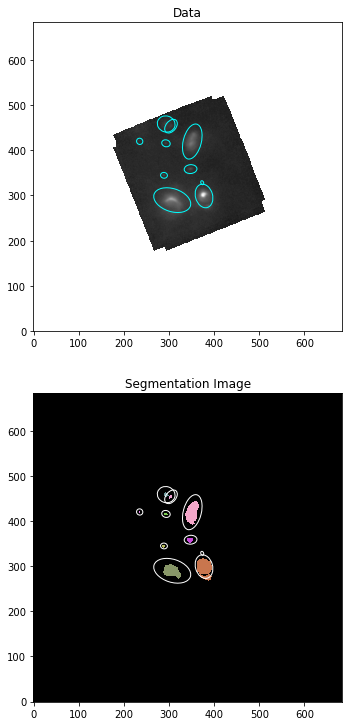

In [20]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

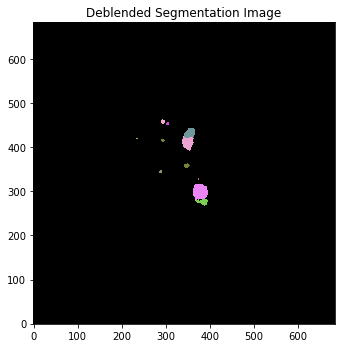

In [21]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [22]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,307.10955838018106,289.65713923468724,"266.3858372347621,-28.937078029781063",0.04973997174237778,0.14717543200259658,122.15560856215517,830.0,8.832980338288136,5.302355306236961,-17.964972105742937,0.014981356898137389,0.013350342535406753,0.033403853905031214,0.7997819471846863,0.399709372922189,1.6658597600764766,17.154384285359114,528.0410725149873,nan,1.9135398250804552,414.15140486009557,nan
2,373.5469370718658,328.2302075121976,"266.36964261552487,-28.928849112406557",-0.007874454671668949,0.011200234002158277,0.056001170010791385,5.0,0.683034896558573,0.46335612804889614,-68.74452310652298,4.327250510125839,1.6989445057326327,2.473889409596207,0.7347126859969342,0.3216215886135746,1.4741035139315024,1.3743311326688228,1.046358448384852,nan,2.6749182103951883,0.3926595240519184,nan
3,288.84360248323105,344.61504371643565,"266.39028845453373,-28.925353336460407",0.09036771719750358,-0.0018762765579371974,-0.06942223264367631,37.0,1.5763554899467505,1.3224248639292384,-8.0380349838433,0.40574317518069014,0.046905519476298015,0.5685062697208747,0.5442657840440308,0.1610871580915355,1.1920189440956395,3.4261232294733075,5.584629152111464,nan,1.9322249409490193,4.087949971393657,nan
4,347.7702616221459,358.4081383624951,"266.3759257377551,-28.922411382422414",-0.00173255466194119,-0.0033145427821535396,-0.3513415349082752,106.0,3.006160557719949,2.084788825973954,4.802693096941039,0.11149330392696766,-0.019926964837551388,0.2292412767551131,0.7204513492958238,0.30649451819194173,1.4419496690824578,6.091511592856108,16.609547855297638,nan,1.879718587005133,12.088382455091336,nan
5,293.23929394132017,415.538575872664,"266.3892153708775,-28.910223078755866",-0.0053855471190476945,-0.009212183748166538,-0.3408507986821619,37.0,1.6589952351795823,1.3307182499233863,-15.340968611485089,0.3774320670761606,0.10275644910269538,0.5506179988086599,0.5971588385573277,0.19787699102141232,1.2466915782323538,3.5412752227735758,4.881841301530958,nan,2.2892270740268312,2.972267763958164,nan
6,235.05716194342656,419.88908151696666,"266.4033943670544,-28.9092930234946",-0.027048960381607316,-0.0037096969618267773,-0.033387272656440994,9.0,0.8001678228256366,0.7666828761216401,-42.474513498189815,1.625411161692643,0.13886531533256888,1.6376847989558536,0.2862579328266901,0.04184740469286918,1.0436750940276431,1.8452469471802622,3.612153539966715,nan,3.539735199653669,0.4896661891047957,nan
7,304.38031775383143,453.4595804174256,"266.38649957134146,-28.9021334688626",-0.03031427671734263,-0.0019146717162873126,-0.0765868686514925,40.0,2.152722066585406,1.3936113608229976,50.59974125657892,0.3943865208446445,-0.2934102836737901,0.3362924741414092,0.7621744366249548,0.35262829212620594,1.5447076043597372,4.27007672217242,17.63801971473737,nan,3.2132008338001468,4.16585530716954,nan
8,293.75240544978874,458.2838382642967,"266.38908932272926,-28.901104101142867",-0.03066989724220506,-0.0022751005939081223,-0.1615321421674767,71.0,2.5084001911236706,2.2438639918401186,-18.336834691158558,0.16285774160499641,0.023700633275506717,0.1946850951507826,0.44698815774045175,0.10546012562893703,1.1178931522790803,5.604025741106372,27.561458737571158,nan,3.162931144520106,7.230759718423276,nan


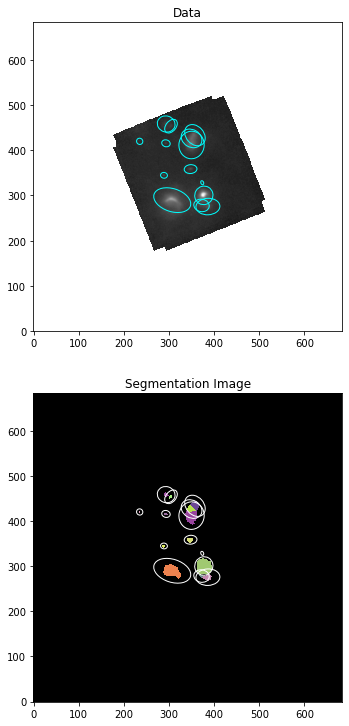

In [23]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [24]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [25]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [26]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,307.10955838018106,289.65713923468724,"266.3858372347621,-28.937078029781063",0.04973997174237778,0.14717543200259658,122.15560856215517,830.0,8.832980338288136,5.302355306236961,-17.964972105742937,0.014981356898137389,0.013350342535406753,0.033403853905031214,0.7997819471846863,0.399709372922189,1.6658597600764766,17.154384285359114,528.0410725149873,1.5109804415058972,1.9135398250804552,414.15140486009557,0.74961865,0.14661921239014547,0.14938562672692754,0.019241179014928902,37.081458763652535
2,373.5469370718658,328.2302075121976,"266.36964261552487,-28.928849112406557",-0.007874454671668949,0.011200234002158277,0.056001170010791385,5.0,0.683034896558573,0.46335612804889614,-68.74452310652298,4.327250510125839,1.6989445057326327,2.473889409596207,0.7347126859969342,0.3216215886135746,1.4741035139315024,1.3743311326688228,1.046358448384852,0.17071594457075628,2.6749182103951883,0.3926595240519184,0.057474658,0.011515017896329367,0.011502825500904286,0.0011177546279809998,1.1579462284206195
3,288.84360248323105,344.61504371643565,"266.39028845453373,-28.925353336460407",0.09036771719750358,-0.0018762765579371974,-0.06942223264367631,37.0,1.5763554899467505,1.3224248639292384,-8.0380349838433,0.40574317518069014,0.046905519476298015,0.5685062697208747,0.5442657840440308,0.1610871580915355,1.1920189440956395,3.4261232294733075,5.584629152111464,0.32307016088874674,1.9322249409490193,4.087949971393657,0.15905964,-0.0018605048878192927,-0.0019276792455111776,0.0017437713208079708,10.250040220334219
4,347.7702616221459,358.4081383624951,"266.3759257377551,-28.922411382422414",-0.00173255466194119,-0.0033145427821535396,-0.3513415349082752,106.0,3.006160557719949,2.084788825973954,4.802693096941039,0.11149330392696766,-0.019926964837551388,0.2292412767551131,0.7204513492958238,0.30649451819194173,1.4419496690824578,6.091511592856108,16.609547855297638,0.5264372838279547,1.879718587005133,12.088382455091336,0.25967154,-0.003273200503542858,-0.003176841249069821,0.0011532088388536714,23.722257504796975
5,293.23929394132017,415.538575872664,"266.3892153708775,-28.910223078755866",-0.0053855471190476945,-0.009212183748166538,-0.3408507986821619,37.0,1.6589952351795823,1.3307182499233863,-15.340968611485089,0.3774320670761606,0.10275644910269538,0.5506179988086599,0.5971588385573277,0.19787699102141232,1.2466915782323538,3.5412752227735758,4.881841301530958,0.3946363874832444,2.2892270740268312,2.972267763958164,0.1592183,-0.00922006573715977,-0.009258583884475683,0.00013303139189274098,7.448888009895745
6,235.05716194342656,419.88908151696666,"266.4033943670544,-28.9092930234946",-0.027048960381607316,-0.0037096969618267773,-0.033387272656440994,9.0,0.8001678228256366,0.7666828761216401,-42.474513498189815,1.625411161692643,0.13886531533256888,1.6376847989558536,0.2862579328266901,0.04184740469286918,1.0436750940276431,1.8452469471802622,3.612153539966715,0.34507051612685385,3.539735199653669,0.4896661891047957,0.08103824,-0.0037096969618267773,-0.003702388855403019,0.0005644208984747927,1.7201056658704166
7,304.38031775383143,453.4595804174256,"266.38649957134146,-28.9021334688626",-0.03031427671734263,-0.0019146717162873126,-0.0765868686514925,40.0,2.152722066585406,1.3936113608229976,50.59974125657892,0.3943865208446445,-0.2934102836737901,0.3362924741414092,0.7621744366249548,0.35262829212620594,1.5447076043597372,4.27007672217242,17.

In [27]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [28]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,307.10955838010005,289.6571392345663,"266.3858372347621,-28.937078029781063",26.927040272220992,0.12001204565839566,97.12310507226957,0.23990502837975544,181.86805290889794,0.3601231205791391,263.78505242176095,0.4803138113871644,333.7588498420966,0.6005114894181289
2,373.546937071977,328.2302075121408,"266.36964261552487,-28.928849112406557",0.9826646537053677,0.11846133828121116,0.9182500050723926,0.2362528091812306,0.4334973198683467,0.35427905430622014,0.7478570115503493,0.47264006847873863,1.951585519443773,0.5908211377598319
3,288.84360248319757,344.615043716442,"266.39028845453373,-28.925353336460407",3.1088499823116105,0.12067910825648763,5.1574234874882965,0.24135371261599833,5.641248592892092,0.36180449894242817,5.484576779449098,0.48228429728000843,4.9018356787677195,0.6026968188026575
4,347.7702616221349,358.40813836248196,"266.3759257377551,-28.922411382422414",4.363282261200236,0.11605446332736721,10.596413263656629,0.23264591547920505,14.541628449999596,0.34920842696417514,16.658900862995342,0.46587166203756686,17.389622927038957,0.5829254097206527
5,293.23929394129897,415.5385758725933,"266.3892153708775,-28.910223078755866",2.156198078234736,0.12076135428583745,3.914091330831441,0.24183421809179229,4.507351260031363,0.36258819139358345,5.0666230198451325,0.4832051172864451,4.88889833109143,0.6041423841378317
6,235.05716194338333,419.88908151696614,"266.4033943670544,-28.9092930234946",0.9723362508940161,0.12541271903806486,2.6695292745245456,0.25745250704324635,4.071465347268593,0.38974547697223594,5.144515141939024,0.5223789002955508,6.078352777744767,0.6545660396676535
7,304.38031775374094,453.45958041736446,"266.38649957134146,-28.9021334688626",2.3744494473554925,0.1334511287004216,6.775356372722882,0.2618586038325143,11.256264521337389,0.38956971319905165,16.080863881255155,0.5239312062516489,21.5131863717123,0.6611383811704896
8,293.7524054497059,458.28383826424266,"266.38908932272926,-28.901104101142867",2.472509735236699,0.1489218082791051,8.139267460841701,0.2931540403342917,14.462235726477306,0.443213481408123,21.074047204501916,0.6035496597646244,28.269724836070353,0.7638543129970448


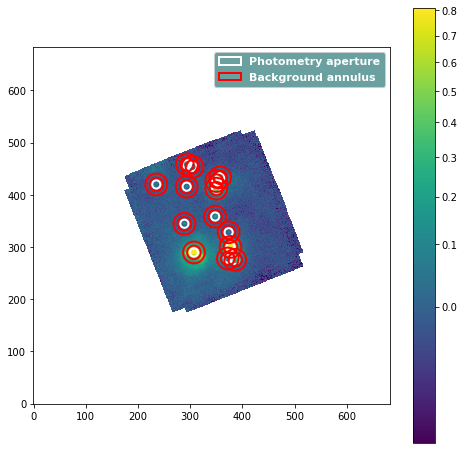

In [29]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [30]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [31]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-31-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,307.10955838010005,289.6571392345663,"266.3858372347621,-28.937078029781063",181.86805290889794,0.3601231205791391,0.10114524015003551,0.1174014977664801,162.4736963458335,0.3601231205791391,0.10114524015003551,32.95049537938621
2,373.546937071977,328.2302075121408,"266.36964261552487,-28.928849112406557",0.4334973198683467,0.35427905430622014,0.0007810390273920361,0.0039847534511107605,0.2837349646211741,0.35427905430622014,0.0007810390273920361,0.36023958468920964
3,288.84360248319757,344.615043716442,"266.39028845453373,-28.925353336460407",5.641248592892092,0.36180449894242817,-0.00029167116785936613,-0.0011870375729287716,5.697175837913596,0.36180449894242817,0.0,8.537570975457633
4,347.7702616221349,358.40813836248196,"266.3759257377551,-28.922411382422414",14.541628449999596,0.34920842696417514,-0.0013089013995985525,-0.0025119219929406926,14.792607145705423,0.34920842696417514,0.0,22.563893996267232
5,293.23929394129897,415.5385758725933,"266.3892153708775,-28.910223078755866",4.507351260031363,0.36258819139358345,-0.001035454607905926,-0.0024689034023652632,4.705897191019383,0.36258819139358345,0.0,7.044453257367894
6,235.05716194338333,419.88908151696614,"266.4033943670544,-28.9092930234946",4.071465347268593,0.38974547697223594,0.0015065765256720414,0.0029150868661192357,3.782582921510507,0.38974547697223594,0.001506576525672041,4.1388938293509
7,304.38031775374094,453.45958041736446,"266.38649957134146,-28.9021334688626",11.256264521337389,0.38956971319905165,0.0002237634568215813,0.003953643605139138,11.213358416601821,0.38956971319905165,0.0002237634568215813,15.369738353194371
8,293.7524054497059,458.28383826424266,"266.38908932272926,-28.901104101142867",14.462235726477306,0.443213481408123,8.575025974393906e-05,-0.0010870202646039323,14.445793320385015,0.443213481408123,8.575025974393907e-05,19.205988666942282


In [32]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [33]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,307.10955838018106,289.65713923468724,"266.3858372347621,-28.937078029781063",0.04973997174237778,0.14717543200259658,122.15560856215517,830.0,8.832980338288136,5.302355306236961,-17.964972105742937,0.014981356898137389,0.013350342535406753,0.033403853905031214,0.7997819471846863,0.399709372922189,1.6658597600764766,17.154384285359114,528.0410725149873,1.5109804415058972,1.9135398250804552,414.15140486009557,0.74961865,0.14661921239014547,0.14938562672692754,0.019241179014928902,37.081458763652535,26.927040272220992,0.12001204565839566,97.12310507226957,0.23990502837975544,181.86805290889794,0.3601231205791391,263.78505242176095,0.4803138113871644,333.7588498420966,0.6005114894181289,0.10114524015003551,0.1174014977664801,162.4736963458335,0.3601231205791391,0.10114524015003551,32.95049537938621,24.772111765213836,88.50339104424093,229.3061963096464,279.88563716691755,16.21736578520105,28.317210069595436,32.657744959577535,29.60256853618149,32.95049537938621,C7HSouth,25.2
2,373.5469370718658,328.2302075121976,"266.36964261552487,-28.928849112406557",-0.007874454671668949,0.011200234002158277,0.056001170010791385,5.0,0.683034896558573,0.46335612804889614,-68.74452310652298,4.327250510125839,1.6989445057326327,2.473889409596207,0.7347126859969342,0.3216215886135746,1.4741035139315024,1.3743311326688228,1.046358448384852,0.17071594457075628,2.6749182103951883,0.3926595240519184,0.057474658,0.011515017896329367,0.011502825500904286,0.0011177546279809998,1.1579462284206195,0.9826646537053677,0.11846133828121116,0.9182500050723926,0.2362528091812306,0.4334973198683467,0.35427905430622014,0.7478570115503493,0.47264006847873863,1.951585519443773,0.5908211377598319,0.0007810390273920361,0.0039847534511107605,0.2837349646211741,0.35427905430622014,0.0007810390273920361,0.36023958468920964,0.9660243920112375,0.8516889582958715,0.4816128244442648,1.5355789770905157,2.5951361902779104,1.473978744681524,0.4718031056842686,1.1946395840065083,2.5951361902779104,C7HSouth,25.2
3,288.84360248323105,344.61504371643565,"266.39028845453373,-28.925353336460407",0.09036771719750358,-0.0018762765579371974,-0.06942223264367631,37.0,1.5763554899467505,1.3224248639292384,-8.0380349838433,0.40574317518069014,0.046905519476298015,0.5685062697208747,0.5442657840440308,0.1610871580915355,1.1920189440956395,3.4261232294733075,5.584629152111464,0.32307016088874674,1.9322249409490193,4.087949971393657,0.15905964,-0.0018605048878192927,-0.0019276792455111776,0.0017437713208079708,10.250040220334219,3.1088499823116105,0.12067910825648763,5.1574234874882965,0.24135371261599833,5.641248592892092,0.36180449894242817,5.484576779449098,0.48228429728000843,4.9018356787677195,0.6026968188026575,-0.0002916711

In [34]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [35]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,307.10955838018106,289.65713923468724,"266.3858372347621,-28.937078029781063",0.04973997174237778,0.14717543200259658,122.15560856215517,830.0,8.832980338288136,5.302355306236961,-17.964972105742937,0.014981356898137389,0.013350342535406753,0.033403853905031214,0.7997819471846863,0.399709372922189,1.6658597600764766,17.154384285359114,528.0410725149873,1.5109804415058972,1.9135398250804552,414.15140486009557,0.74961865,0.14661921239014547,0.14938562672692754,0.019241179014928902,37.081458763652535,26.927040272220992,0.12001204565839566,97.12310507226957,0.23990502837975544,181.86805290889794,0.3601231205791391,263.78505242176095,0.4803138113871644,333.7588498420966,0.6005114894181289,0.10114524015003551,0.1174014977664801,162.4736963458335,0.3601231205791391,0.10114524015003551,32.95049537938621,24.772111765213836,88.50339104424093,229.3061963096464,279.88563716691755,16.21736578520105,28.317210069595436,32.657744959577535,29.60256853618149,32.95049537938621,C7HSouth,25.2
3,288.84360248323105,344.61504371643565,"266.39028845453373,-28.925353336460407",0.09036771719750358,-0.0018762765579371974,-0.06942223264367631,37.0,1.5763554899467505,1.3224248639292384,-8.0380349838433,0.40574317518069014,0.046905519476298015,0.5685062697208747,0.5442657840440308,0.1610871580915355,1.1920189440956395,3.4261232294733075,5.584629152111464,0.32307016088874674,1.9322249409490193,4.087949971393657,0.15905964,-0.0018605048878192927,-0.0019276792455111776,0.0017437713208079708,10.250040220334219,3.1088499823116105,0.12067910825648763,5.1574234874882965,0.24135371261599833,5.641248592892092,0.36180449894242817,5.484576779449098,0.48228429728000843,4.9018356787677195,0.6026968188026575,-0.00029167116785936613,-0.0011870375729287716,5.697175837913596,0.36180449894242817,0.0,8.537570975457633,3.115064120647333,5.182280040831188,5.584002992820661,5.057189137160788,8.85428001415909,10.045971959496814,6.770878804136742,5.085130038935031,10.045971959496814,C7HSouth,25.2
4,347.7702616221459,358.4081383624951,"266.3759257377551,-28.922411382422414",-0.00173255466194119,-0.0033145427821535396,-0.3513415349082752,106.0,3.006160557719949,2.084788825973954,4.802693096941039,0.11149330392696766,-0.019926964837551388,0.2292412767551131,0.7204513492958238,0.30649451819194173,1.4419496690824578,6.091511592856108,16.609547855297638,0.5264372838279547,1.879718587005133,12.088382455091336,0.25967154,-0.003273200503542858,-0.003176841249069821,0.0011532088388536714,23.722257504796975,4.363282261200236,0.11605446332736721,10.596413263656629,0.23264591547920505,14.541628449999596,0.34920842696417514,16.658900862995342,0.46587166203756686,17.389622927038957,0.5829254097206527,-0.0013089013995985525,-0.0025119

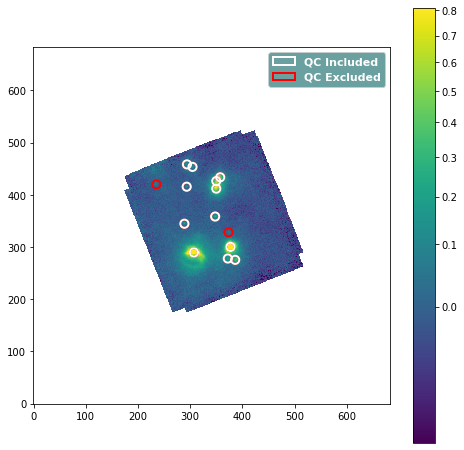

In [36]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

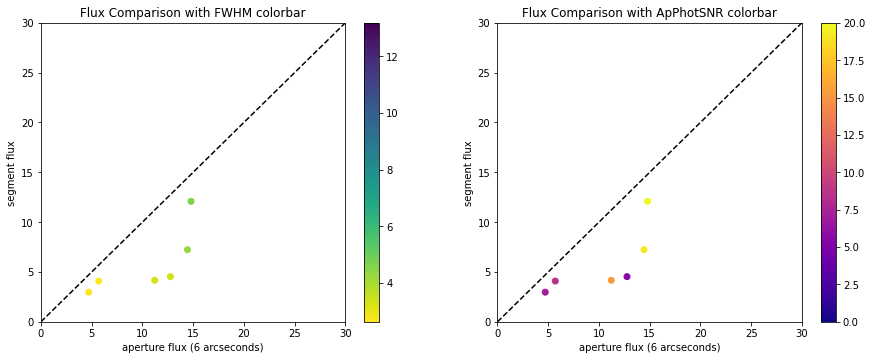

In [37]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

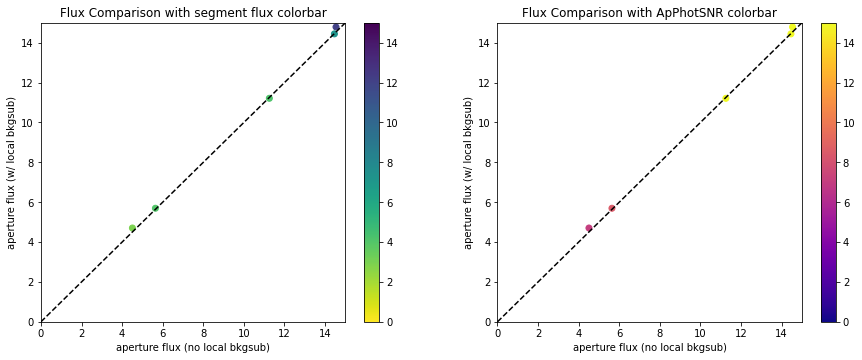

In [38]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [39]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)